# Credit Default Classifier #
Use machine learning to predict the probability of default for a given customer, knowing certain of its features.

### JP Morgan Instructions ###
1. You should produce a function that can take in the properties of a loan and output the expected loss.
2. You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

In [26]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [27]:
# Importing data
credit_df = pd.read_csv("credit_data.csv")
credit_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [28]:
# Getting general information about the data
print(credit_df.info())
print(credit_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB
None
        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.000000e+04              10000.000000          10000.000000   
mean   4.974577e+06                  1.461200           4159.677034   
std    2.293890e+06                  1.743846           1421.399078   
mi

In [29]:
def data_splits(X, y):
    """
    Split the 'features' and 'labels' data into training and testing sets.
    Input(s): X: features (pd.DataFrame), y: labels (pd.DataFrame)
    Output(s): X_train, X_test, y_train, y_test
    """
    # Use random_state = 0 in the train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=0, shuffle = True)

    #Flattening the y_sets
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()

    return X_train, X_test, y_train, y_test

In [30]:
def normalize_features(X_train, X_test):
    """
    Take the input data and normalize the features.
    Input: X_train: features for train,  X_test: features for test (pd.DataFrame)
    Output: X_train_scaled, X_test_scaled (pd.DataFrame) the same shape of X_train and X_test
    """
    # Normalize the features with MinMaxScaler
    # Train and test normalization with Train max and min values
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [31]:
def normalize_features(X_train, X_test):
    """
    Take the input data and normalize the features.
    Input: X_train: features for train,  X_test: features for test (pd.DataFrame)
    Output: X_train_scaled, X_test_scaled (pd.DataFrame) the same shape of X_train and X_test
    """
    # Normalize the features with MinMaxScaler
    # Train and test normalization with Train max and min values
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [32]:
def train_model(model_name, X_train_scaled, y_train):
    '''
    inputs:
       - model_name: the name of learning algorithm to be trained
       - X_train: features training set
       - y_train: label training set
    output: cls: the trained model
    '''
    if model_name == 'Decision Tree':
        # Trained model for Decision Tree
        cls = DecisionTreeClassifier(random_state=0)
    elif model_name == 'Random Forest':
        # Trained model for Random Forest
        cls = RandomForestClassifier(random_state=0)
    elif model_name == 'SVM':
        cls = SVC(random_state=0)

    # Training the model
    cls.fit(X_train_scaled, y_train)

    return cls

In [33]:
def eval_model(trained_models, X_train, X_test, y_train, y_test):
    '''
    inputs:
       - trained_models: a dictionary of the trained models,
       - X_train: features training set
       - X_test: features test set
       - y_train: label training set
       - y_test: label test set
    outputs:
        - y_train_pred_dict: a dictionary of label predicted for train set of each model
        - y_test_pred_dict: a dictionary of label predicted for test set of each model
        - a dict of accuracy and f1_score of train and test sets for each model
    '''
    evaluation_results = {}
    y_train_pred_dict = {
        'Decision Tree': None,
        'Random Forest': None,
        'SVM': None}
    y_test_pred_dict = {
        'Decision Tree': None,
        'Random Forest': None,
        'SVM': None}

    # Loop through each trained model
    for model_name, model in trained_models.items():
        # Predictions for training and testing sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Calculate F1-score
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Store predictions
        y_train_pred_dict[model_name] = y_train_pred
        y_test_pred_dict[model_name] = y_test_pred

        # Store the evaluation metrics
        evaluation_results[model_name] = {
            'Train Accuracy': train_accuracy ,
            'Test Accuracy': test_accuracy ,
            'Train F1 Score': train_f1 ,
            'Test F1 Score': test_f1 ,
        }

    # Return the evaluation results
    return y_train_pred_dict, y_test_pred_dict, evaluation_results

In [34]:
def report_model(y_train, y_test, y_train_pred_dict, y_test_pred_dict):
    '''
    inputs:
        - y_train: label training set
        - y_test: label test set
        - y_train_pred_dict: a dictionary of label predicted for train set of each model, len(y_train_pred_dict.keys)=3
        - y_test_pred_dict: a dictionary of label predicted for test set of each model, len(y_train_pred_dict.keys)=3
    '''

    # Loop through each trained model
    for model_name, model in trained_models.items():
        print(f"\nModel: {model_name}")

        # Predictions for training and testing sets
        y_train_pred = y_train_pred_dict[model_name]
        y_test_pred = y_test_pred_dict[model_name]

        # Print classification report for training set
        print("\nTraining Set Classification Report:")
        # Write Classification Report train
        print(classification_report(y_train, y_train_pred))

        # Print confusion matrix for training set
        print("Training Set Confusion Matrix:")
        # Write Confusion Matrix train
        print(confusion_matrix(y_train, y_train_pred))

        # Print classification report for testing set
        print("\nTesting Set Classification Report:")
        # Write Classification Report test
        print(classification_report(y_test, y_test_pred))

        # Print confusion matrix for testing set
        print("Testing Set Confusion Matrix:")
        # Write Confusion Matrix test
        print(confusion_matrix(y_test, y_test_pred))

In [35]:
features = ['credit_lines_outstanding','loan_amt_outstanding','total_debt_outstanding','income','years_employed','fico_score']
X = credit_df[features]
y = credit_df['default']
X_train, X_test, y_train, y_test = data_splits(X,y) # Split data
X_train_scaled, X_test_scaled = normalize_features(X_train, X_test) # Normalize data

cls_decision_tree = train_model('Decision Tree', X_train_scaled, y_train) #  Train the model
cls_randomforest = train_model('Random Forest', X_train_scaled, y_train) # Train the model
cls_svm = train_model('SVM', X_train_scaled, y_train) # Train the model

# Define a dictionary of model name and their trained model
trained_models = {
        'Decision Tree': cls_decision_tree,
        'Random Forest': cls_randomforest,
        'SVM': cls_svm }

# predict labels and calculate accuracy and F1score
y_train_pred_dict, y_test_pred_dict, evaluation_results = eval_model(trained_models, X_train_scaled, X_test_scaled, y_train, y_test)

# Only to visualise the results
for model in trained_models:
    print(f'\nModel selected: {model} on the training set:')
    print(f'{model} accuracy: {evaluation_results[model]["Train Accuracy"]}')
    print(f'{model} F1-score: {evaluation_results[model]["Train F1 Score"]}')

    print(f'\nModel selected: {model} on the test set:')
    print(f'{model} accuracy: {evaluation_results[model]["Test Accuracy"]}')
    print(f'{model} F1-score: {evaluation_results[model]["Test F1 Score"]}')


# classification report and calculate confusion matrix
report_model(y_train, y_test, y_train_pred_dict, y_test_pred_dict)


Model selected: Decision Tree on the training set:
Decision Tree accuracy: 1.0
Decision Tree F1-score: 1.0

Model selected: Decision Tree on the test set:
Decision Tree accuracy: 0.991
Decision Tree F1-score: 0.9748603351955307

Model selected: Random Forest on the training set:
Random Forest accuracy: 1.0
Random Forest F1-score: 1.0

Model selected: Random Forest on the test set:
Random Forest accuracy: 0.9935
Random Forest F1-score: 0.9818688981868898

Model selected: SVM on the training set:
SVM accuracy: 0.997125
SVM F1-score: 0.9922792883517959

Model selected: SVM on the test set:
SVM accuracy: 0.9955
SVM F1-score: 0.9874125874125874

Model: Decision Tree

Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6508
           1       1.00      1.00      1.00      1492

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1

In [36]:
# Step 1: Create hyperparameter grids for each model
# Fill out below dictionaries with reasonable values
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 30, 50, 70]
}

param_grid_random_forest = {
    'n_estimators': [150, 200, 250],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'shrinking': [True, False],
    'C': [0.01, 0.1, 1, 10],
    # 'tol': [1e-3, 1e-4, 1e-5]
    # 'gamma': ['scale', 'auto']
}

In [37]:
# Step 2: Initialize classifiers with random_state=0
decision_tree = DecisionTreeClassifier(random_state=0)
random_forest = RandomForestClassifier(random_state=0)
svm = SVC(random_state=0)

In [38]:
# Step 3: Create a scorer using accuracy
scorer = 'accuracy'

In [39]:
# Step 4: Perform grid search for each model using 10-fold StratifiedKFold cross-validation
def perform_grid_search(model, X_train, y_train, params):
    # Define the cross-validation strategy
    strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # Grid search for the model
    grid_search = GridSearchCV(
        estimator = model,
        param_grid = params,
        scoring = scorer,
        cv = strat_kfold,
        n_jobs = -1,
        verbose = 1
    )
    
    # Fit to the data
    grid_search.fit(X_train, y_train)
    
    best_param = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Grid search on :", model)
    print("Best parameters are:", best_param)
    print("Best score is:", best_score)

    # Return the fitted grid search objects
    return grid_search, best_param, best_score

In [40]:
# Step 5: Perform grid search for each model using 10-fold StratifiedKFold cross-validation
# Do Grid search for Decision Tree
grid_decision_tree, best_params_decision_tree, best_score_decision_tree  = perform_grid_search(
    model = decision_tree,
    X_train = X_train_scaled,
    y_train = y_train,
    params = param_grid_decision_tree
)

# Do Grid search for Random Forest
grid_random_forest, best_params_random_forest, best_score_random_forest  = perform_grid_search(
    model = random_forest,
    X_train = X_train_scaled,
    y_train = y_train,
    params = param_grid_random_forest
)

# Do Grid search for SVM
grid_svm, best_params_svm, best_score_svm = perform_grid_search(
    model = svm,
    X_train = X_train_scaled,
    y_train = y_train,
    params = param_grid_svm
)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
Grid search on : DecisionTreeClassifier(random_state=0)
Best parameters are: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
Best score is: 0.9961249999999999
Fitting 10 folds for each of 24 candidates, totalling 240 fits
Grid search on : RandomForestClassifier(random_state=0)
Best parameters are: {'bootstrap': False, 'max_depth': None, 'n_estimators': 200}
Best score is: 0.9957499999999999
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Grid search on : SVC(random_state=0)
Best parameters are: {'C': 10, 'kernel': 'poly', 'shrinking': True}
Best score is: 0.999


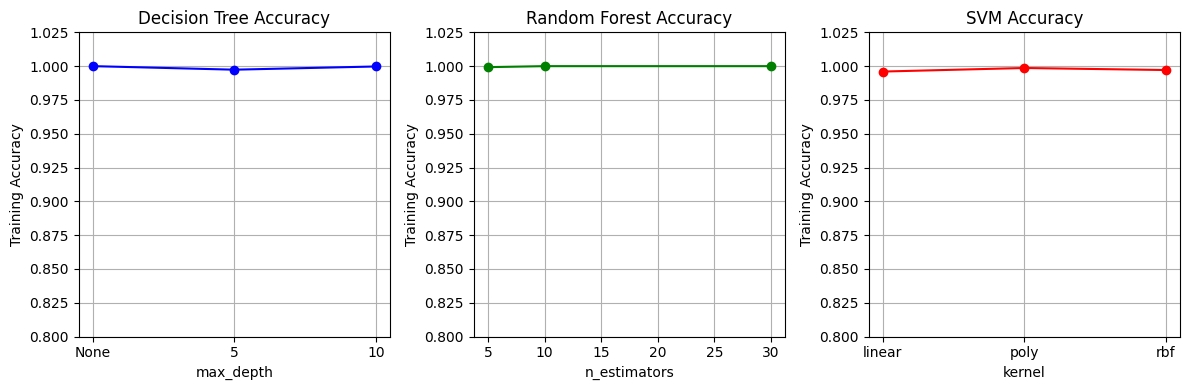

In [41]:
'''
UNCOMMENT THIS SECTION FOR PLOTTING TRAINING ACCURACY VS HYPERPARAMETERS
'''
def plot_hyperparameter_effect(X_train, y_train):
    # 1. Decision Tree: Testing different values for max_depth
    max_depth_values = [None, 5, 10]
    decision_tree_accuracies = []
    
    for depth in max_depth_values:
        dt_model = DecisionTreeClassifier(max_depth=depth, random_state=0)
        dt_model.fit(X_train, y_train)
        y_pred_train = dt_model.predict(X_train)
        accuracy = accuracy_score(y_train, y_pred_train)
        decision_tree_accuracies.append(accuracy)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(['None', '5', '10'], decision_tree_accuracies, marker='o', color='blue')
    plt.title('Decision Tree Accuracy')
    plt.xlabel('max_depth')
    plt.ylabel('Training Accuracy')
    plt.ylim(0.8, 1.025)
    plt.grid(True)
    
    # 2. Random Forest: Testing different values for n_estimators
    n_estimators_values = [5, 10, 30]
    random_forest_accuracies = []
    
    for n in n_estimators_values:
        rf_model = RandomForestClassifier(n_estimators=n, random_state=0)
        rf_model.fit(X_train, y_train)
        y_pred_train = rf_model.predict(X_train)
        accuracy = accuracy_score(y_train, y_pred_train)
        random_forest_accuracies.append(accuracy)
    
    plt.subplot(1, 3, 2)
    plt.plot(n_estimators_values, random_forest_accuracies, marker='o', color='green')
    plt.title('Random Forest Accuracy')
    plt.xlabel('n_estimators')
    plt.ylabel('Training Accuracy')
    plt.ylim(0.8, 1.025)
    plt.grid(True)
    
    # 3. SVM: Testing different kernel types
    kernel_values = ['linear', 'poly', 'rbf']
    svm_accuracies = []
    
    for kernel in kernel_values:
        svm_model = SVC(kernel=kernel, random_state=0)
        svm_model.fit(X_train, y_train)
        y_pred_train = svm_model.predict(X_train)
        accuracy = accuracy_score(y_train, y_pred_train)
        svm_accuracies.append(accuracy)
    
    plt.subplot(1, 3, 3)
    plt.plot(kernel_values, svm_accuracies, marker='o', color='red')
    plt.title('SVM Accuracy')
    plt.xlabel('kernel')
    plt.ylabel('Training Accuracy')
    plt.ylim(0.8, 1.025)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Call the function using your preprocessed data
plot_hyperparameter_effect(X_train_scaled, y_train)



Test Accuracies:
Decision Tree: 0.9935
Random Forest: 0.9940
SVM: 0.9980


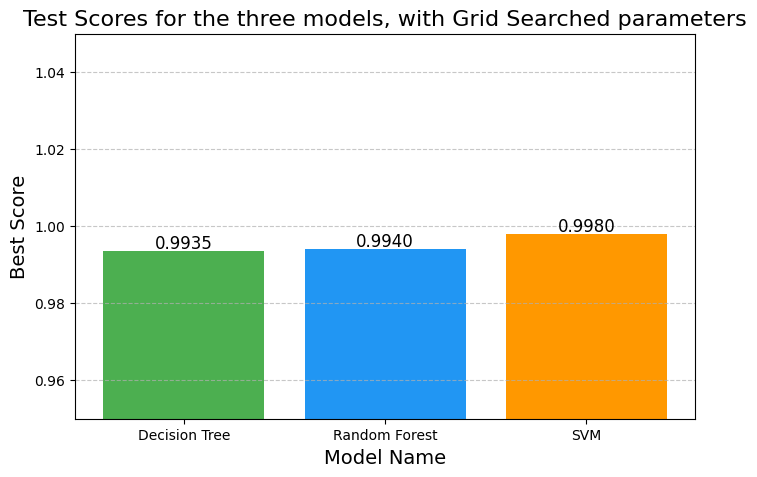

In [45]:
'''
UNCOMMENT THIS SECTION FOR PLOTTING TEST ACCURACY FOR BEST PARAMETERS
'''
# Extract the best models from your GridSearchCV results
decision_tree_best_param = grid_decision_tree.best_estimator_
random_forest_best_param = grid_random_forest.best_estimator_
svm_best_param = grid_svm.best_estimator_

# Calculate test accuracies for each model
accuracy_decision_tree = decision_tree_best_param.score(X_test_scaled, y_test)
accuracy_random_forest = random_forest_best_param.score(X_test_scaled, y_test)
accuracy_svm = svm_best_param.score(X_test_scaled, y_test)

# Store the results in a dictionary for easy plotting
test_accuracies = {
    'Decision Tree': accuracy_decision_tree,  #accuracy_decision_tree,
    'Random Forest':  accuracy_random_forest, #accuracy_random_forest,
    'SVM': accuracy_svm #accuracy_svm
}

#Print the test accuracies values
print("\nTest Accuracies:")
for model, acc in test_accuracies.items():
    print(f"{model}: {acc:.4f}")


# Plotting
plt.figure(figsize=(8, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color=['#4CAF50', '#2196F3', '#FF9800'])

# Adding titles and labels
plt.title('Test Scores for the three models, with Grid Searched parameters', fontsize=16)
plt.xlabel('Model Name', fontsize=14)
plt.ylabel('Best Score', fontsize=14)
plt.ylim(0.95, 1.05)  # Setting y-axis limits for better visualization

# Annotate the bars with the score values
for i, score in enumerate(test_accuracies.values()):
    plt.text(i, score + 0.0007, f'{score:.4f}', ha='center', fontsize=12)

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [72]:
# Final Step : Evaluating the loan risk of the retail bank
loan_df = pd.read_csv('credit_data.csv')

In [73]:
# Data preprocessing
features = ['credit_lines_outstanding','loan_amt_outstanding','total_debt_outstanding','income','years_employed','fico_score']
X = credit_df[features]
y = credit_df['default']

# Defining model with best hyperparameters
default_model = SVC(C=10, kernel='poly', shrinking=True, random_state=0, probability=True)
# Fitting the model on the new data
default_model.fit(X, y)

SVC(C=10, kernel='poly', probability=True, random_state=0)

In [74]:
# Ideally we would like to have a new client DataFrame but
# for this example we will use the same DataFrame
loan_df.drop(columns='default', inplace=True)
# This way this simulate a new clients DataFrame
loan_df


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631
...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647


In [75]:
# Getting probabilies of default for each client
probability_default = default_model.predict_proba(loan_df[features])[:, 1]
probability_df = pd.DataFrame(probability_default.round(decimals = 2), columns = ['probability_default'])
loan_df = pd.concat([loan_df, probability_df], axis = 1)
loan_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,probability_default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0.00
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,0.52
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0.00
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0.00
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0.19
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0.01
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0.00
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0.09
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0.00


In [76]:
recovery_rate = 0.1     # given by the bank
# Generating necessary data for the retail bank
loan_df['default'] = loan_df['probability_default'].apply(lambda x: 1 if x > 0.5 else 0)
# Loss Given Default column
loan_df['loss_given_default'] = (1-recovery_rate)*loan_df['loan_amt_outstanding']
# Expected Loss column
loan_df['expected_loss'] = loan_df['loss_given_default']*loan_df['probability_default']
# Resulting dataframe
loan_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,probability_default,default,loss_given_default,expected_loss
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0.00,0,4699.390674,0.000000
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,0.52,1,1763.035853,916.778644
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0.00,0,3026.708333,0.000000
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0.00,0,4289.983201,0.000000
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0.19,0,1211.244946,230.136540
...,...,...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0.01,0,2730.282393,27.302824
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0.00,0,3731.615374,0.000000
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0.09,0,2779.401354,250.146122
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0.00,0,2960.011499,0.000000


In [84]:
total_lgd = loan_df['loss_given_default'].sum()
total_exp_loss = loan_df['expected_loss'].sum()
numb_defaulters = loan_df['default'].sum()
numb_subscribers = loan_df.index.size
total_loan_amt = loan_df['loan_amt_outstanding'].sum()

print(f'The bank has a total of {numb_subscribers:,} subscribers.')
print(f'From these {numb_subscribers:,} subscribers, {numb_defaulters:,} have high risk of default, representing a default rate of {(numb_defaulters / numb_subscribers) * 100:.2f}%.')
print(f'The bank has a total credit of {total_loan_amt:,.2f}$ in outstanding loans.')
print(f'With current ML models and given recovery rates, the bank is expected to lose {total_exp_loss:,.2f}$ in expected losses.')
print(f'On the other side, if all the loans default, the bank will lose {total_lgd:,.2f}$ in losses.')
print(f'The expected exposure of the bank is {total_exp_loss / total_loan_amt * 100:.2f}%.')
print(f'While the total loss exposure of the bank is {total_lgd / total_loan_amt * 100:.2f}%.')

The bank has a total of 10,000 subscribers.
From these 10,000 subscribers, 1,755 have high risk of default, representing a default rate of 17.55%.
The bank has a total credit of 41,596,770.34$ in outstanding loans.
With current ML models and given recovery rates, the bank is expected to lose 7,380,021.15$ in expected losses.
On the other side, if all the loans default, the bank will lose 37,437,093.31$ in losses.
The expected exposure of the bank is 17.74%.
While the total loss exposure of the bank is 90.00%.
